### Performance Benchmarking: Pandoc vs. LibreOffice

The purpose of this document is to compare and benchmark the time is takes to convert a ``.docx`` file to a ``.pdf`` using the ``pandoc/latex:2.17`` and ``instructure/libreoffice:6.3`` Docker images. It’s important to note that the findings below should be used as an indicator only. Actual performance largely depends on the capability and resource consumption of the executing machine. Therefore, it’s expected that results vary between executions.

Conversion time, while it plays a role, is not the only metric that should be considered when determining which Docker image is used in favor of the other. Metrics such as conversion quality, image size, maintainability etc should be considered.

Note: A Docker daemon must be running in the background before executing this file.

In [10]:
# Uncomment the following packages should they need to be installed
 
# %pip install matplotlib
# %pip install numpy

In [11]:
# Prepares the directory for the converted files

import os

def directory_setup():
    if not os.path.isdir("converted_files"):
        os.makedirs("converted_files")

    if not os.path.isdir("converted_files/libreoffice"):
        os.makedirs("converted_files/libreoffice")

    if not os.path.isdir("converted_files/pandoc"):
        os.makedirs("converted_files/pandoc")

    return

directory_setup()

In [12]:
# Converts a given .docx file to a .pdf using Pandoc and LibreOffice and measures the time it took

import time

def compare_conversion_time(incoming_file):

    outgoing_file = f"{incoming_file.split('.')[0]}.pdf"

    # Pandoc

    if os.path.exists(f"converted_files/pandoc/{outgoing_file}"):
        os.remove(f"converted_files/pandoc/{outgoing_file}")

    t1 = time.time()
    _ = !docker run -d --rm --volume "$(pwd):/data" pandoc/latex:2.17 "{incoming_file}" --from docx --to pdf -o "./converted_files/pandoc/{outgoing_file}"
    t2 = time.time()

    duration_1 = t2 - t1

    # LibreOffice
    
    if os.path.exists(f"converted_files/libreoffice/{outgoing_file}"):
        os.remove(f"converted_files/libreoffice/{outgoing_file}")

    t1 = time.time()
    _ = !docker run -d --rm --volume "$(pwd):/data" instructure/libreoffice:6.3 bash -c "cd data && soffice --headless --convert-to pdf --outdir ./converted_files/libreoffice {incoming_file}"
    t2 = time.time()

    duration_2 = t2 - t1

    return {
        "p": duration_1,
        "l": duration_2
    }

Install Pandoc Docker Image

*If you have not previously installed this image, this step may take some time.*

In [13]:
output = !docker pull -q pandoc/latex:2.17

print(f"Successfully pulled {output[0]}")

Successfully pulled docker.io/pandoc/latex:2.17


Install LibreOffice Docker Image

*If you have not previously installed this image, this step may take some time.*

In [14]:
output = !docker pull -q instructure/libreoffice:6.3

print(f"Successfully pulled {output[0]}")

Successfully pulled docker.io/instructure/libreoffice:6.3


#### Conversion Test Cases

In the below code block we test the conversion performance using three sample files of different sizes. These are ``file-sample_100kb.docx``, ``file-sample_500kb.docx``, and ``file-sample_1MB.docx``.

Each file is subjected to ``3`` conversion rounds, of which, the best, worst and average conversion times are recorded.

In [15]:
import numpy as np

CONVERSION_ROUNDS = 3

conversion_files = ["file-sample_100kb.docx", "file-sample_500kb.docx", "file-sample_1MB.docx"]
conversion_files_results = []

print(f"Each file will be converted {CONVERSION_ROUNDS} times")

print("\n")

for conversion_file in conversion_files:
    print(f"Converting {conversion_file} to {conversion_file.split('.')[0]}.pdf")
    
    results_internal_p = []
    results_internal_l = []

    for i in range(CONVERSION_ROUNDS):
        results = compare_conversion_time(conversion_file)
        results_internal_p.append(results["p"])
        results_internal_l.append(results["l"])

    conversion_files_results.append({
        "conversion_file": conversion_file,
        "conversion_file_result": {
            "p": {
                "min": np.min(results_internal_p),
                "max": np.max(results_internal_p),
                "avg": np.mean(results_internal_p),
                "raw": results_internal_p
            },
            "l": {
                "min": np.min(results_internal_l),
                "max": np.max(results_internal_l),
                "avg": np.mean(results_internal_l),
                "raw": results_internal_l
            }
        }
    })

print("\n")
import json
for conversion_files_result in conversion_files_results:
    print(json.dumps(conversion_files_result, indent=3))

print("\n")

print("Converted files are available under './converted_files'")

Each file will be converted 3 times


Converting file-sample_100kb.docx to file-sample_100kb.pdf
Converting file-sample_500kb.docx to file-sample_500kb.pdf
Converting file-sample_1MB.docx to file-sample_1MB.pdf


{
   "conversion_file": "file-sample_100kb.docx",
   "conversion_file_result": {
      "p": {
         "min": 0.39881181716918945,
         "max": 0.5820209980010986,
         "avg": 0.5073512395222982,
         "raw": [
            0.39881181716918945,
            0.5412209033966064,
            0.5820209980010986
         ]
      },
      "l": {
         "min": 0.4338099956512451,
         "max": 0.6113042831420898,
         "avg": 0.5338107744852701,
         "raw": [
            0.4338099956512451,
            0.6113042831420898,
            0.5563180446624756
         ]
      }
   }
}
{
   "conversion_file": "file-sample_500kb.docx",
   "conversion_file_result": {
      "p": {
         "min": 0.64292311668396,
         "max": 0.8235929012298584,
         "avg": 0.71888756

#### Conversion Analysis

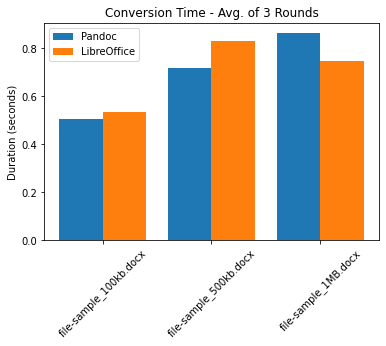

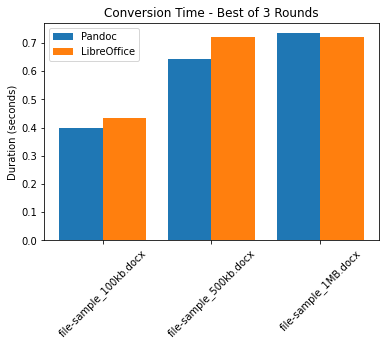

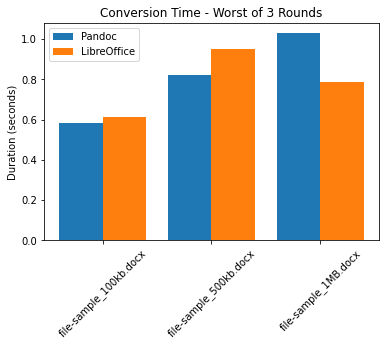

In [16]:
import matplotlib.pyplot as plt

# Compare the average of X rounds of conversions between Pandoc and LibreOffice

x1_avg = np.arange(len(conversion_files))

y1_avg = []
y2_avg = []

for conversion_files_result in conversion_files_results:
    y1_avg.append(conversion_files_result["conversion_file_result"]["p"]["avg"])
    y2_avg.append(conversion_files_result["conversion_file_result"]["l"]["avg"])
  
fig_avg, ax_avg = plt.subplots()

ax_avg.set_title(f"Conversion Time - Avg. of {CONVERSION_ROUNDS} Rounds")

x2_avg = [x + 0.40 for x in x1_avg]

ax_avg.bar(x1_avg, y1_avg, 0.40, label="Pandoc")
ax_avg.bar(x2_avg, y2_avg, 0.40, label="LibreOffice")

ax_avg.legend()
ax_avg.set_ylabel('Duration (seconds)')

ax_avg.set_xticks([r + 0.20 for r in range(len(conversion_files))])
ax_avg.set_xticklabels(conversion_files, rotation=45)

plt.show()

# Compare the best of X rounds of conversions between Pandoc and LibreOffice

x1_min = np.arange(len(conversion_files))

y1_min = []
y2_min = []

for conversion_files_result in conversion_files_results:
    y1_min.append(conversion_files_result["conversion_file_result"]["p"]["min"])
    y2_min.append(conversion_files_result["conversion_file_result"]["l"]["min"])
  
fig_min, ax_min = plt.subplots()

ax_min.set_title(f"Conversion Time - Best of {CONVERSION_ROUNDS} Rounds")

x2_min = [x + 0.40 for x in x1_min]

ax_min.bar(x1_min, y1_min, 0.40, label="Pandoc")
ax_min.bar(x2_min, y2_min, 0.40, label="LibreOffice")

ax_min.legend()
ax_min.set_ylabel('Duration (seconds)')

ax_min.set_xticks([r + 0.20 for r in range(len(conversion_files))])
ax_min.set_xticklabels(conversion_files, rotation=45)

plt.show()

# Compare the worst of X rounds of conversions between Pandoc and LibreOffice

x1_max = np.arange(len(conversion_files))

y1_max = []
y2_max = []

for conversion_files_result in conversion_files_results:
    y1_max.append(conversion_files_result["conversion_file_result"]["p"]["max"])
    y2_max.append(conversion_files_result["conversion_file_result"]["l"]["max"])
  
fig_max, ax_max = plt.subplots()

ax_max.set_title(f"Conversion Time - Worst of {CONVERSION_ROUNDS} Rounds")

x2_max = [x + 0.40 for x in x1_max]

ax_max.bar(x1_max, y1_max, 0.40, label="Pandoc")
ax_max.bar(x2_max, y2_max, 0.40, label="LibreOffice")

ax_max.legend()
ax_max.set_ylabel('Duration (seconds)')

ax_max.set_xticks([r + 0.20 for r in range(len(conversion_files))])
ax_max.set_xticklabels(conversion_files, rotation=45)

plt.show()


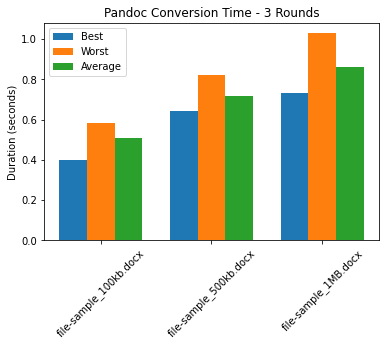

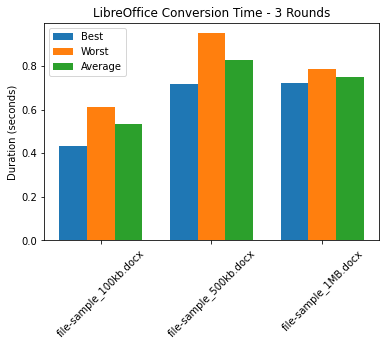

In [17]:
# Compare best, worst and average conversion time for each file using Pandoc

x1_p = np.arange(len(conversion_files))

y1_p = []
y2_p = []
y3_p = []

for conversion_files_result in conversion_files_results:
    y1_p.append(conversion_files_result["conversion_file_result"]["p"]["min"])
    y2_p.append(conversion_files_result["conversion_file_result"]["p"]["max"])
    y3_p.append(conversion_files_result["conversion_file_result"]["p"]["avg"])
  
fig_p, ax_p = plt.subplots()

ax_p.set_title(f"Pandoc Conversion Time - {CONVERSION_ROUNDS} Rounds")

x2_p = [x + 0.25 for x in x1_p]
x3_p = [x + 0.25 for x in x2_p]

ax_p.bar(x1_p, y1_p, 0.25, label="Best")
ax_p.bar(x2_p, y2_p, 0.25, label="Worst")
ax_p.bar(x3_p, y3_p, 0.25, label="Average")

ax_p.legend()
ax_p.set_ylabel('Duration (seconds)')

ax_p.set_xticks([r + 0.25 for r in range(len(conversion_files))])
ax_p.set_xticklabels(conversion_files, rotation=45)

plt.show()

# Compare best, worst and average conversion time for each file using LibreOffice

x1_l = np.arange(len(conversion_files))

y1_l = []
y2_l = []
y3_l = []

for conversion_files_result in conversion_files_results:
    y1_l.append(conversion_files_result["conversion_file_result"]["l"]["min"])
    y2_l.append(conversion_files_result["conversion_file_result"]["l"]["max"])
    y3_l.append(conversion_files_result["conversion_file_result"]["l"]["avg"])
  
fig_l, ax_l = plt.subplots()

ax_l.set_title(f"LibreOffice Conversion Time - {CONVERSION_ROUNDS} Rounds")

x2_l = [x + 0.25 for x in x1_l]
x3_l = [x + 0.25 for x in x2_l]

ax_l.bar(x1_l, y1_l, 0.25, label="Best")
ax_l.bar(x2_l, y2_l, 0.25, label="Worst")
ax_l.bar(x3_l, y3_l, 0.25, label="Average")

ax_l.legend()
ax_l.set_ylabel('Duration (seconds)')

ax_l.set_xticks([r + 0.25 for r in range(len(conversion_files))])
ax_l.set_xticklabels(conversion_files, rotation=45)

plt.show()


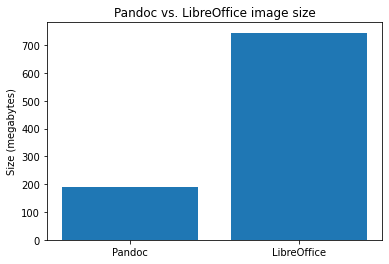

In [18]:
# Compare the compressed size of each Docker image

fig, ax = plt.subplots()

ax.set_title("Pandoc vs. LibreOffice image size")
ax.set_ylabel("Size (megabytes)")
ax.bar(["Pandoc", "LibreOffice"], [191.19, 744.85])

# Sources: https://hub.docker.com/r/pandoc/latex/tags, https://hub.docker.com/r/instructure/libreoffice

plt.show()